# Compare OceanParcels and Ariane

In [24]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from salishsea_tools import nc_tools, places

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D, AdvectionAnalytical

%matplotlib inline 
# ^ a magic funtion that renders the figure in the notebook right after the cell and will be stored in the notebook document

# ariane

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/salish_qual/forward_01mar19/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

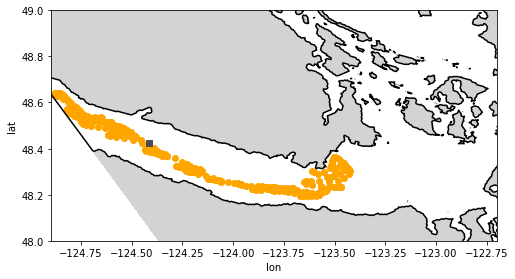

In [3]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

# ocean parcels

In [4]:
def fieldset_from_nemo(daterange, coords, flat=True):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d))
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):
        
        # Exclude vertical velocity if 2D
        if flat:
            if var == 'W': break

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields if 3D (f-points are on W grid)
        if not flat:
            filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
            dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)# field_chunksize='auto')
    
    return field_set

def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

In [5]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/rbeutel/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc',
    'out': './results',
}

In [6]:
# Duration and timestep [s]
length = 10
duration = timedelta(days=length)
dt = 90

In [7]:
# Define release parameters
n = 1   # number of particles

lon, lat = file.traj_lon[0],file.traj_lat[0]
zvals = file.traj_depth[0]*(-1) #m

# Forcing daterange (I add 1-day buffers)
start = datetime(2019, 3, 1)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [8]:
# Set output file name.  Maybe change for each run
fn = f'ariane_compare' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/ariane_compare20190301_20190311.nc


In [9]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False) #flat=False forces it to care about bathymetry

         It will be opened with no decoding. Filling values might be wrongly parsed.


In [10]:
# Execute
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-2919/8e8f5ec621ba74694ae4f2beff9a7f47_0.so
INFO: Temporary output files are stored in ./results/out-QNNBIVBC.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-QNNBIVBC" to convert these to a NetCDF file during the run.
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:05:37 Time:  0:05:37


In [11]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [12]:
data = xr.open_dataset(outfile)

# compare the tracks

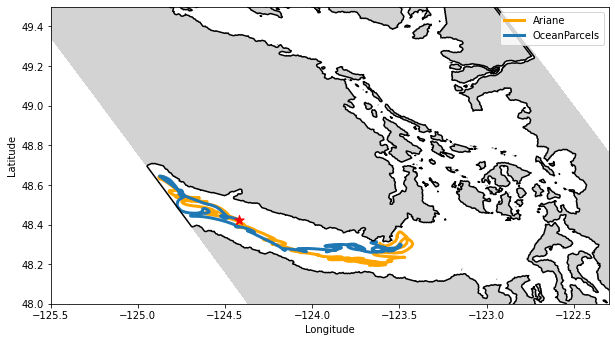

In [22]:
#surface
fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')


ax.plot(file.traj_lon,file.traj_lat,color='orange', label='Ariane', linewidth='3',zorder=0)
ax.plot(data.lon[0, nmin:nmax], data.lat[0, nmin:nmax], label='OceanParcels', linewidth='3',zorder=0)
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='r',marker='*',zorder=1,s=100)

plt.legend()

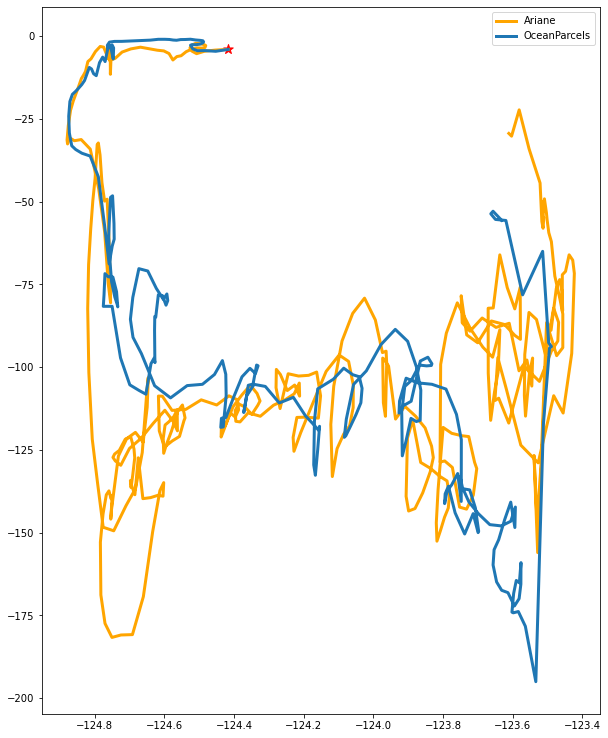

In [23]:
#depth
fig, ax = plt.subplots(figsize=(10, 13))

ax.plot(file.traj_lon,file.traj_depth,color='orange', label='Ariane', linewidth='3')
ax.plot(data.lon[0, nmin:nmax], -data.z[0, nmin:nmax], label='OceanParcels', linewidth='3')
ax.scatter(file.traj_lon[0],file.traj_depth[0],color='r',marker='*',zorder=1,s=100)

plt.legend()

# compare with analytical scheme too

In [26]:
# Set output file name.  Maybe change for each run
fn = f'ariane_compare_analytical_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/ariane_compare_analytical_20190301_20190311.nc


In [27]:
# Execute
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionAnalytical), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

NotImplementedError: Analytical Advection only works in Scipy mode